# Scenario Generation and KSS Analysis

This notebook generates light exposure scenarios with a maximum of 250 lux (0.27329575 melanopic irradiance) lasting 3 hours, using pulses, sustained, or combinations. Outside these 3 hours, 50 lux (0.05465915 melanopic irradiance) is used during the day, and 0 lux (0 melanopic irradiance) is used at night (10 PM to 6 AM).

For each scenario, the model is run and KSS values are calculated. The delta between the initial and final KSS values (after 3 hours) is computed. Scenarios with similar KSS delta (< 0.1) are identified, and their irradiance and KSS curves are plotted on adjacent plots.

> EML * 0.91 * 1.2013e-3 = melanopic irradiance (W/m^2)
> EML * 0.91 = MEDI
> MEDI * 1.2013e-3 = melanopic irradiance (W/m^2)

In [2]:
import constants

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

scenarios = {}

# Constants for irradiance
MAX_IRRADIANCE = 0.27329575
DAY_IRRADIANCE = 0.02186366 # 0.05465915
NIGHT_IRRADIANCE = 0.0

# Time setup
minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60

def is_night(hour):
    return hour < 6 or hour >= 22

def generate_scenario(pattern_type, start_hour=12.5, duration=3):
    '''Generate a scenario with a 3-hour window of max irradiance, rest is day/night pattern.'''
    irradiance = []
    for h in hours:
        if is_night(h):
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            if pattern_type == 'sustained':
                irradiance.append(MAX_IRRADIANCE)
            elif pattern_type == 'pulse':
                # Pulse: alternate every 30 min
                if int((h - start_hour) * 2) % 2 == 0:
                    irradiance.append(MAX_IRRADIANCE)
                else:
                    irradiance.append(DAY_IRRADIANCE)
            elif pattern_type == 'combination':
                # Combination: first half sustained, second half pulses
                if h < start_hour + duration/2:
                    irradiance.append(MAX_IRRADIANCE)
                else:
                    if int((h - (start_hour + duration/2)) * 2) % 2 == 0:
                        irradiance.append(MAX_IRRADIANCE)
                    else:
                        irradiance.append(DAY_IRRADIANCE)
        else:
            irradiance.append(DAY_IRRADIANCE)
    return np.array(irradiance)

# Example scenarios
scenarios = {
    'sustained': generate_scenario('sustained'),
    'pulse': generate_scenario('pulse'),
    'combination': generate_scenario('combination')
}

In [193]:
def generate_short_pulse_scenario(pulse_length_min=5, interval_min=15, start_hour=12.5, duration=3):
    '''Generate a scenario with short pulses (1-10 min) and variable intervals during a 3-hour window.'''
    irradiance = []
    pulse_start = start_hour * 60
    pulse_end = (start_hour + duration) * 60
    for i, h in enumerate(hours):
        minute = int(h * 60)
        if is_night(h):
            irradiance.append(NIGHT_IRRADIANCE)
        elif pulse_start <= minute < pulse_end:
            # Calculate if current minute is within a pulse
            cycle = (minute - pulse_start) // (pulse_length_min + interval_min)
            cycle_start = pulse_start + cycle * (pulse_length_min + interval_min)
            if cycle_start <= minute < cycle_start + pulse_length_min:
                irradiance.append(MAX_IRRADIANCE)
            else:
                irradiance.append(DAY_IRRADIANCE)
        else:
            irradiance.append(DAY_IRRADIANCE)
    return np.array(irradiance)

# Example: 5-min pulses every 15 min, 3-hour window starting at 8 AM
scenarios['short_pulse_05_15'] = generate_short_pulse_scenario(pulse_length_min=5, interval_min=15)
scenarios['short_pulse_01_30'] = generate_short_pulse_scenario(pulse_length_min=1, interval_min=30)
scenarios['short_pulse_10_05'] = generate_short_pulse_scenario(pulse_length_min=10, interval_min=5)
scenarios['short_pulse_01_01'] = generate_short_pulse_scenario(pulse_length_min=1, interval_min=1)

In [194]:
scenarios

{'sustained': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,)),
 'pulse': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,)),
 'combination': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,)),
 'short_pulse_05_15': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,)),
 'short_pulse_01_30': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,)),
 'short_pulse_10_05': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,)),
 'short_pulse_01_01': array([0., 0., 0., ..., 0., 0., 0.], shape=(1440,))}

In [199]:
import models

results = {}
for name in scenarios:
    irradiance = scenarios[name]
    interpolator = lambda t: np.interp(t/3600, hours, irradiance)
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(12.5 * 60)
    end_idx = int((12.5 + 3) * 60)
    delta_kss = KSS[end_idx] - KSS[start_idx]
    results[name] = {
        'irradiance': irradiance,
        'KSS': KSS,
        'Theta_L': Theta_L,
        'delta_kss': delta_kss,
        't': t
    }
    print(f"{name}: delta KSS = {delta_kss:.3f}")

    # --- Plot interpolated irradiance
    # interp_values = [interpolator(minute) for minute in range(0, 24*60)]
    # interp_hours = np.arange(0, 24*60) / 60
    # plt.figure(figsize=(8, 4))
    # plt.plot(interp_hours, interp_values, label=f'Interpolator: {name}', color='tab:purple')
    # plt.title(f'Interpolator Output for Scenario: {name}')
    # plt.xlabel('Hour')
    # plt.ylabel('Interpolated Melanopic Irradiance')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

sustained: delta KSS = -1.348
pulse: delta KSS = -0.271
combination: delta KSS = -1.075
short_pulse_05_15: delta KSS = -0.234
short_pulse_01_30: delta KSS = 0.001
short_pulse_10_05: delta KSS = -0.835
short_pulse_01_01: delta KSS = -1.139


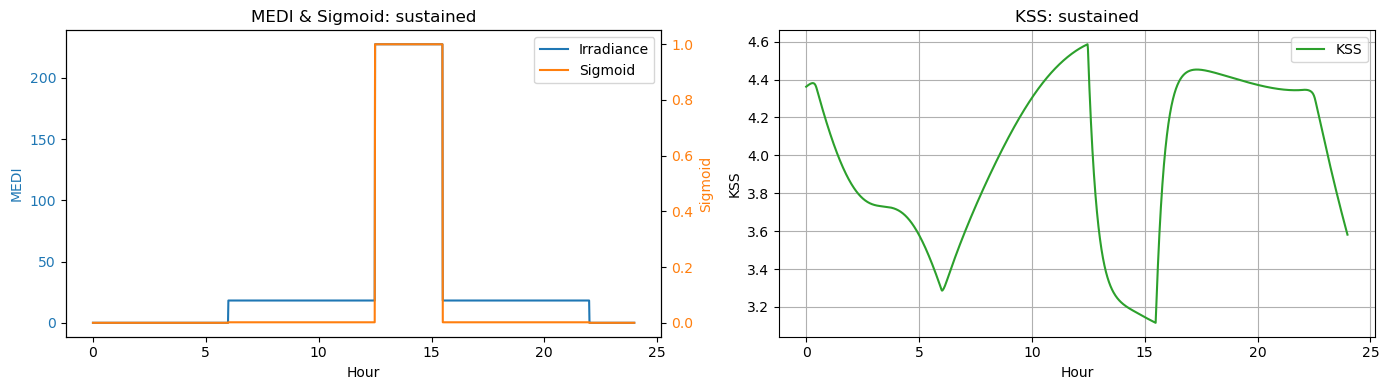

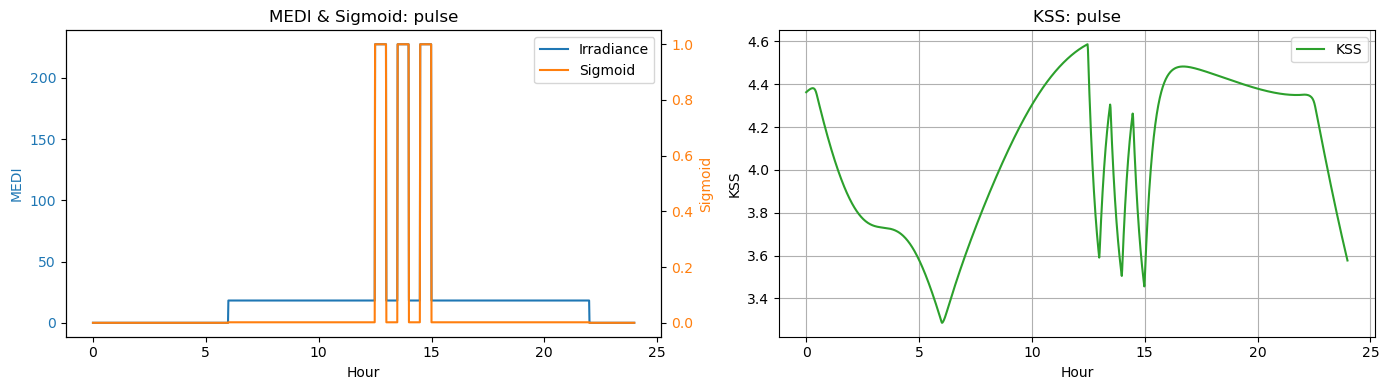

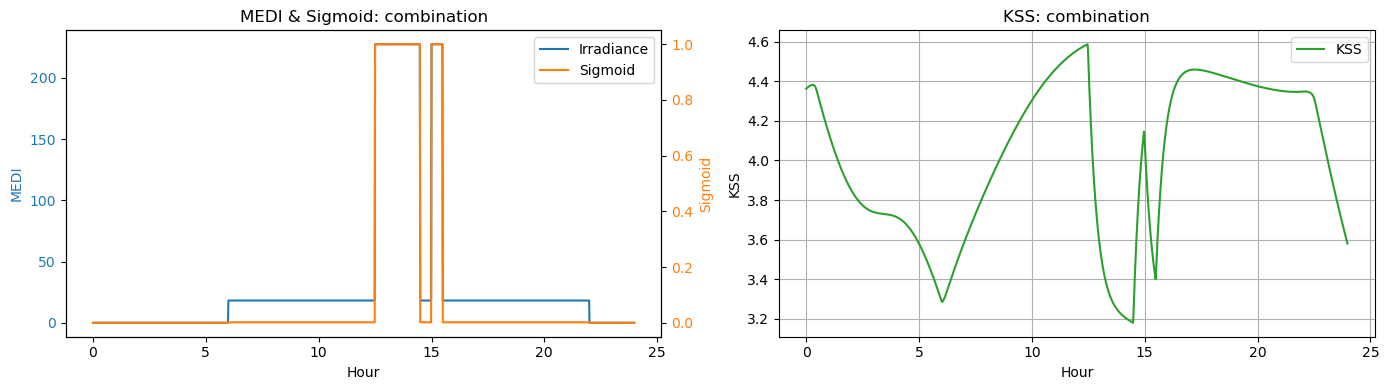

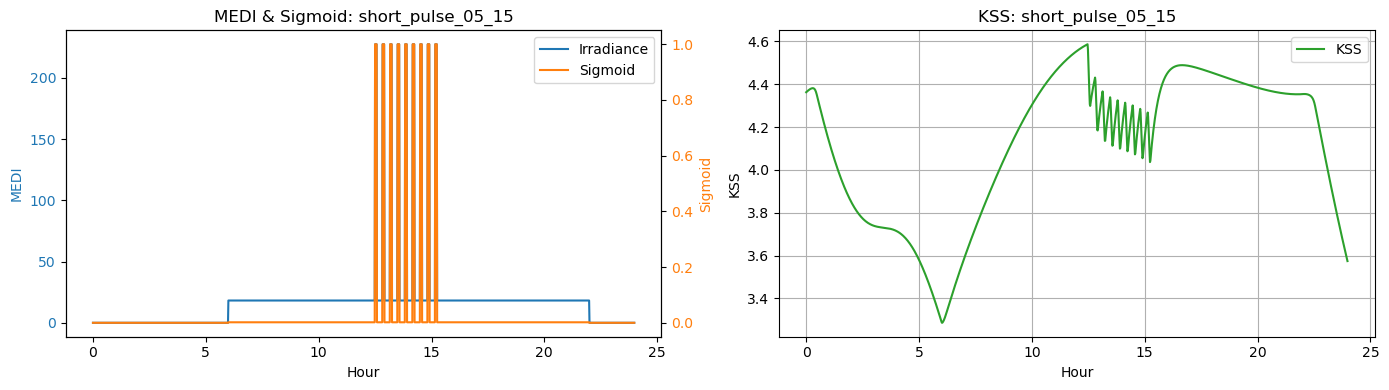

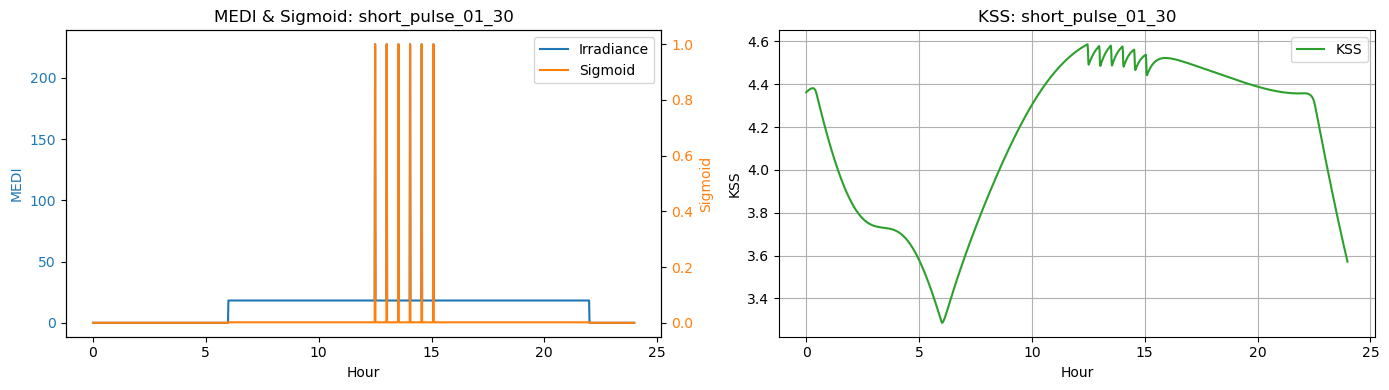

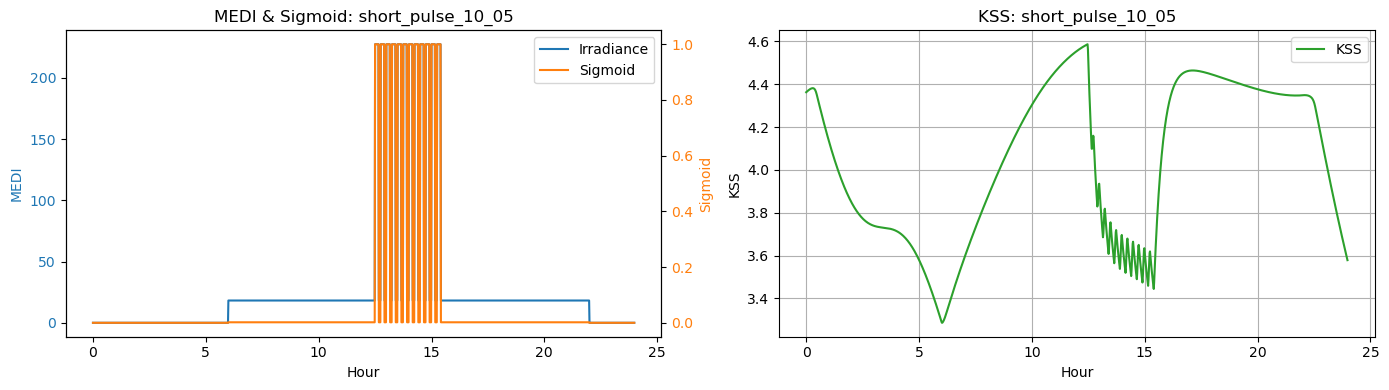

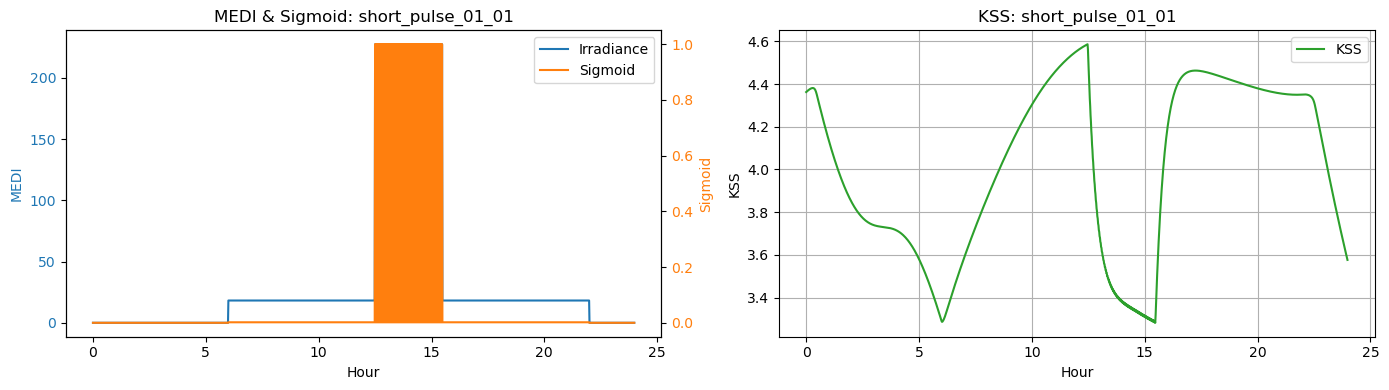

In [200]:
for name in scenarios:
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(14, 4))

    # Irradiance and Sigmoid (left plot)
    ax1.plot(hours, results[name]['irradiance']/1.2013e-3, color='tab:blue', label='Irradiance')
    ax1.set_title(f'MEDI & Sigmoid: {name}')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('MEDI', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    sigmoid = [models.sigmoid(irr) for irr in results[name]['irradiance']]
    ax2 = ax1.twinx()
    ax2.plot(hours, sigmoid, color='tab:orange', label='Sigmoid')
    ax2.set_ylabel('Sigmoid', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Legends for left plot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # KSS (right plot)
    ax3.plot(hours, results[name]['KSS'], color='tab:green', label='KSS')
    ax3.set_title(f'KSS: {name}')
    ax3.set_xlabel('Hour')
    ax3.set_ylabel('KSS')
    ax3.legend(loc='upper right')
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [17]:
# Optimzation for constant scenario (1)
def constant(max):
    DAY_IRRADIANCE = 0.02186366 # 0.05465915
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3

    irradiance = []
    for h in hours:
        if h < 6 or h >= 22:
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            irradiance.append(max)
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import brentq

def find_max_for_delta_kss(target_delta=-1.10, lower=0.0, upper=0.5):
    # Define the function whose root we want to find
    def func(max_val):
        return constant(max_val) - target_delta
    # Use brentq to find the root
    result = brentq(func, lower, upper)
    return result

max_value = find_max_for_delta_kss(-1.10)
print(f"Max irradiance for delta KSS: {max_value:.4f}")
print(f"Delta KSS = {constant(max_value):.4f}")

Max irradiance for delta KSS: 0.0569
Delta KSS = -1.1000


In [15]:
def pulses(max, pulse_length_min, interval_min):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3

    irradiance = []
    pulse_start = start_hour * 60
    pulse_end = (start_hour + duration) * 60
    for i, h in enumerate(hours):
        minute = int(h * 60)
        if is_night(h):
            irradiance.append(NIGHT_IRRADIANCE)
        elif pulse_start <= minute < pulse_end:
            # Calculate if current minute is within a pulse
            cycle = (minute - pulse_start) // (pulse_length_min + interval_min)
            cycle_start = pulse_start + cycle * (pulse_length_min + interval_min)
            if cycle_start <= minute < cycle_start + pulse_length_min:
                irradiance.append(max)
            else:
                irradiance.append(DAY_IRRADIANCE)
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import minimize

def objective(params, target_delta):
    max_val, pulse_length_min, interval_min = params
    delta = pulses(max_val, pulse_length_min, interval_min)
    print(f"params={params}, delta={delta}, opt={abs(delta - target_delta)}")
    return abs(delta - target_delta) 

x0 = [0.3, 1, 1]
target_delta = -1.2

result = minimize(objective, x0, args=(target_delta,), bounds=[(0, 0.3), (0.5, 30), (0.5, 30)], method='Powell')
if result.success:
    max_val, pulse_length_min, interval_min = result.x
    print(f"Optimized parameters for delta KSS = {target_delta}:")
    print(f"max = {max_val:.4f}, pulse_length_min = {pulse_length_min:.2f}, interval_min = {interval_min:.2f}")
    print(f"delta_KSS = {pulses(max_val, pulse_length_min, interval_min):.4f}")
else:
    print("Optimization failed:", result.message)

# max = 0.1788, pulse_length_min = 2.25, interval_min = 4.36
# delta_KSS = -0.6077220708416582

params=[0.3 1.  1. ], delta=-1.1541212971671069, opt=0.04587870283289308
params=[0.1145898 1.        1.       ], delta=-0.8874233727037066, opt=0.3125766272962933
params=[0.1854102 1.        1.       ], delta=-1.0582782937887782, opt=0.1417217062112217
params=[0.22917961 1.         1.        ], delta=-1.1067075984907082, opt=0.09329240150929174
params=[0.25583439 1.         1.        ], delta=-1.1277035778080937, opt=0.07229642219190624
params=[0.27270415 1.         1.        ], delta=-1.1388050691265073, opt=0.0611949308734927
params=[0.28313024 1.         1.        ], delta=-1.1450110571211325, opt=0.054988942878867464
params=[0.28957391 1.         1.        ], delta=-1.1486174274927112, opt=0.051382572507288726
params=[0.29355632 1.         1.        ], delta=-1.1507613921463413, opt=0.049238607853658634
params=[0.29601759 1.         1.        ], delta=-1.1520672350440258, opt=0.047932764955974205
params=[0.29753873 1.         1.        ], delta=-1.1528587267086703, opt=0.0471412732

KeyboardInterrupt: 

In [19]:
def pulses_30(max, pulse_length_min):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3
    interval_min=30

    irradiance = []
    pulse_start = start_hour * 60
    pulse_end = (start_hour + duration) * 60
    for i, h in enumerate(hours):
        minute = int(h * 60)
        if is_night(h):
            irradiance.append(NIGHT_IRRADIANCE)
        elif pulse_start <= minute < pulse_end:
            # Calculate if current minute is within a pulse
            cycle = (minute - pulse_start) // (pulse_length_min + interval_min)
            cycle_start = pulse_start + cycle * (pulse_length_min + interval_min)
            if cycle_start <= minute < cycle_start + pulse_length_min:
                irradiance.append(max)
            else:
                irradiance.append(DAY_IRRADIANCE)
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import minimize

def objective(params, target_delta):
    max_val, pulse_length_min = params
    delta = pulses_30(max_val, pulse_length_min)
    print(f"params={params}, delta={delta}, opt={abs(delta - target_delta)}")
    return abs(delta - target_delta) 

x0 = [0.3, 40]
target_delta = -1.1

result = minimize(objective, x0, args=(target_delta,), bounds=[(0, 0.6), (10, 60)], method='Powell')
if result.success:
    max_val, pulse_length_min = result.x
    print(f"Optimized parameters for delta KSS = {target_delta}:")
    print(f"max = {max_val:.4f}, pulse_length_min = {pulse_length_min:.2f}, interval_min = {30:.2f}")
    print(f"delta_KSS = {pulses_30(max_val, pulse_length_min):.4f}")
else:
    print("Optimization failed:", result.message)

# max = 0.0929, pulse_length_min = 26.67, interval_min = 30.00
# delta_KSS = -0.6020513139859824

params=[ 0.3 40. ], delta=-1.157489938990583, opt=0.05748993899058297
params=[ 0.22917961 40.        ], delta=-1.152561599778279, opt=0.0525615997782789
params=[ 0.37082039 40.        ], delta=-1.1616606968573726, opt=0.06166069685737252
params=[ 0.14164079 40.        ], delta=-1.1451684546284997, opt=0.04516845462849961
params=[ 0.08753882 40.        ], delta=-1.1384905094632907, opt=0.03849050946329058
params=[ 0.05410197 40.        ], delta=-0.816808097946399, opt=0.2831919020536011
params=[ 0.10820393 40.        ], delta=-1.1415715596052163, opt=0.04157155960521619
params=[ 0.07476708 40.        ], delta=-1.1321447173815393, opt=0.032144717381539234
params=[ 0.06687371 40.        ], delta=-1.109939789221277, opt=0.009939789221276918
params=[ 0.06199534 40.        ], delta=-1.0628828699668835, opt=0.03711713003311656
params=[ 0.06867775 40.        ], delta=-1.1184679533519604, opt=0.018467953351960276
params=[ 0.06501034 40.        ], delta=-1.0971088882147693, opt=0.002891111785230

In [ ]:
# add one peak scenario

In [ ]:
# Optimization for daylight scenario (4)
daytime_df = pd.read_csv('./data/daytime_irradiance_curve.csv')
daytime_df = daytime_df[(daytime_df['time'] >= 8.5) & (daytime_df['time'] <= 18)]
time = daytime_df['time'].values
time = np.linspace(12.5, 15.5, len(time))  # 12:30 to 15:30 in hours
daytime_irradiance = daytime_df['irradiance'].values / constants.CONVERSION_FACTOR
daytime_interpolator = lambda t: np.interp(t, time, np.array(daytime_irradiance))

def daylight(max):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3

    irradiance = []
    for h in hours:
        if h < 6 or h >= 22:
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            irradiance.append(max*daytime_interpolator(h))
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import brentq

def find_max_for_delta_kss_daylight(target_delta=-0.6, lower=0.0, upper=10.0):
    def func(max_val):
        return daylight(max_val) - target_delta
    result = brentq(func, lower, upper)
    return result

max_value = find_max_for_delta_kss_daylight(-0.6)
print(f"Max for delta KSS = -0.6: {max_value:.4f}")

# 0.4997
# KSS delta = -0.599920930989911

Max for delta KSS = -0.6: 0.4997


In [261]:
import numpy as np
from scipy.optimize import brentq

def triangle_scenario(max_peak, start_hour=12.5, duration=3):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0
    minutes_per_day = 24 * 60
    hours = np.arange(0, minutes_per_day) / 60
    midpoint = start_hour + duration / 2

    irradiance = []
    for h in hours:
        if h < 6 or h >= 22:
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            # Triangle: ramp up, then down
            if h <= midpoint:
                val = DAY_IRRADIANCE + (max_peak - DAY_IRRADIANCE) * ((h - start_hour) / (midpoint - start_hour))
            else:
                val = DAY_IRRADIANCE + (max_peak - DAY_IRRADIANCE) * ((start_hour + duration - h) / (midpoint - start_hour))
            irradiance.append(val)
        else:
            irradiance.append(DAY_IRRADIANCE)
    return np.array(irradiance)

def triangle_delta_kss(max_peak):
    irradiance = triangle_scenario(max_peak)
    hours = np.arange(0, 24*60) / 60
    interpolator = lambda t: np.interp(t/3600, hours, irradiance)
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(12.5 * 60)
    end_idx = int((12.5 + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

def find_peak_for_delta_kss(target_delta=-0.6, lower=0.0, upper=0.3):
    def func(max_peak):
        return triangle_delta_kss(max_peak) - target_delta
    result = brentq(func, lower, upper)
    return result

# Example usage:
peak_value = find_peak_for_delta_kss(-0.6)
print(f"Peak irradiance for delta KSS = -0.6: {peak_value:.4f}")
triangle_delta_kss(0.1362)

Peak irradiance for delta KSS = -0.6: 0.1362


np.float64(-0.6000213777266268)

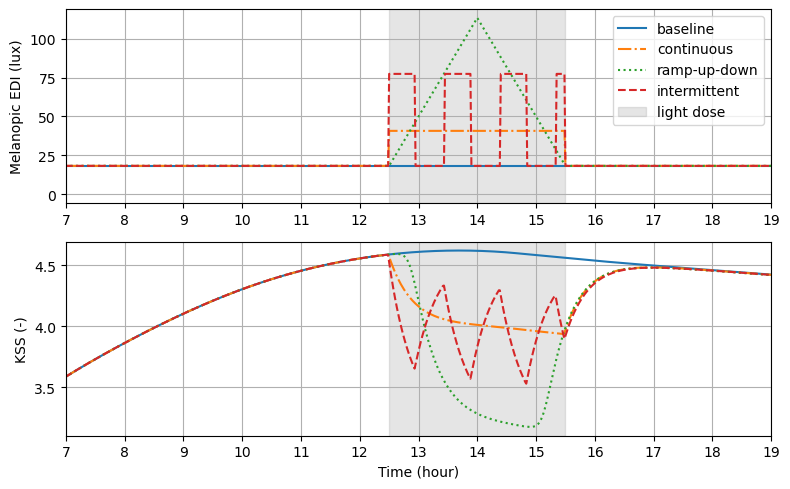

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models

def is_night(hour):
    return hour < 6 or hour >= 22

# Control
DAY_IRRADIANCE = 0.02186366 # 0.05465915
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradianceC = []
for h in hours:
    if h < 6 or h >= 22:
        irradianceC.append(NIGHT_IRRADIANCE)
    else:
        irradianceC.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradianceC))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSSC = models.alertness_measure_v(C, H, Theta_L)

# Scenario 1
DAY_IRRADIANCE = 0.02186366 # 0.05465915
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradiance1 = []
for h in hours:
    if h < 6 or h >= 22:
        irradiance1.append(NIGHT_IRRADIANCE)
    elif start_hour <= h < start_hour + duration:
        irradiance1.append(0.0489)
    else:
        irradiance1.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance1))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS1 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 2
DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradiance2 = []
pulse_start = start_hour * 60
pulse_end = (start_hour + duration) * 60
for i, h in enumerate(hours):
    minute = int(h * 60)
    if is_night(h):
        irradiance2.append(NIGHT_IRRADIANCE)
    elif pulse_start <= minute < pulse_end:
        # Calculate if current minute is within a pulse
        cycle = (minute - pulse_start) // (2.25 + 4.36)
        cycle_start = pulse_start + cycle * (2.25 + 4.36)
        if cycle_start <= minute < cycle_start + 2.25:
            irradiance2.append(0.1788)
        else:
            irradiance2.append(DAY_IRRADIANCE)
    else:
        irradiance2.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance2))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS2 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 3
DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3
interval_min=30

irradiance3 = []
pulse_start = start_hour * 60
pulse_end = (start_hour + duration) * 60
for i, h in enumerate(hours):
    minute = int(h * 60)
    if is_night(h):
        irradiance3.append(NIGHT_IRRADIANCE)
    elif pulse_start <= minute < pulse_end:
        # Calculate if current minute is within a pulse
        cycle = (minute - pulse_start) // (26.67 + interval_min)
        cycle_start = pulse_start + cycle * (26.67 + interval_min)
        if cycle_start <= minute < cycle_start + 26.67:
            irradiance3.append(0.0929)
        else:
            irradiance3.append(DAY_IRRADIANCE)
    else:
        irradiance3.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance3))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS3 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 4
daytime_df = pd.read_csv('./data/daytime_irradiance_curve.csv')
daytime_df = daytime_df[(daytime_df['time'] >= 8.5) & (daytime_df['time'] <= 18)]
time = daytime_df['time'].values
time = np.linspace(12.5, 15.5, len(time))  # 12:30 to 15:30 in hours
daytime_irradiance = daytime_df['irradiance'].values / constants.CONVERSION_FACTOR
daytime_interpolator = lambda t: np.interp(t, time, np.array(daytime_irradiance))

DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradiance4 = []
for h in hours:
    if h < 6 or h >= 22:
        irradiance4.append(NIGHT_IRRADIANCE)
    elif start_hour <= h < start_hour + duration:
        irradiance4.append(0.4997*daytime_interpolator(h))
    else:
        irradiance4.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance4))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS4 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 5
DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0
minutes_per_day = 24 * 60
hours = np.arange(0, minutes_per_day) / 60
midpoint = start_hour + duration / 2

irradiance5 = []
for h in hours:
    if h < 6 or h >= 22:
        irradiance5.append(NIGHT_IRRADIANCE)
    elif start_hour <= h < start_hour + duration:
        # Triangle: ramp up, then down
        if h <= midpoint:
            val = DAY_IRRADIANCE + (0.1362 - DAY_IRRADIANCE) * ((h - start_hour) / (midpoint - start_hour))
        else:
            val = DAY_IRRADIANCE + (0.1362 - DAY_IRRADIANCE) * ((start_hour + duration - h) / (midpoint - start_hour))
        irradiance5.append(val)
    else:
        irradiance5.append(DAY_IRRADIANCE)

hours = np.arange(0, 24*60) / 60
interpolator = lambda t: np.interp(t/3600, hours, irradiance5)
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS5 = models.alertness_measure_v(C, H, Theta_L)

import matplotlib.patches as mpatches

# Plotting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

# TODO: grey out the 12.5-15.5 area and write "light dose"
# TODO: cram plots but has to be legible
# TODO: test print in black and white

for ax in [ax1, ax2]:
    ax.axvspan(12.5, 15.5, color='gray', alpha=0.2, zorder=0)

light_dose_patch = mpatches.Patch(color='gray', alpha=0.2, label='light dose')

# Irradiance plot
ax1.plot(hours, np.array(irradianceC)/1.2013e-3, label="baseline", linestyle="-")
ax1.plot(hours, np.array(irradiance1)/1.2013e-3, label="continuous", linestyle="-.")
ax1.plot(hours, np.array(irradiance5)/1.2013e-3, label="ramp-up-down", linestyle=":")
ax1.plot(hours, np.array(irradiance3)/1.2013e-3, label="intermittent", linestyle="--")
ax1.set_ylabel("Melanopic EDI (lux)")
ax1.set_xlim(7, 19)
ax1.set_xticks(np.arange(7, 20, 1))
handles, labels = ax1.get_legend_handles_labels()
handles.append(light_dose_patch)
labels.append("light dose")
ax1.legend(handles, labels)
ax1.grid(True)

# KSS plot
ax2.plot(hours, np.array(KSSC), label="baseline", linestyle="-")
ax2.plot(hours, np.array(KSS1), label="continuous", linestyle="-.")
ax2.plot(hours, np.array(KSS5), label="ramp-up-down", linestyle=":")
ax2.plot(hours, np.array(KSS3), label="intermittent", linestyle="--")
ax2.set_xlabel("Time (hour)")
ax2.set_ylabel("KSS (-)")
ax2.set_xlim(7, 19)
ax2.set_xticks(np.arange(7, 20, 1))
ax2.grid(True)

plt.tight_layout()
plt.show()